In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Suppress TensorFlow INFO and WARNING messages

In [2]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


E0000 00:00:1730562635.082809  180105 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730562635.089701  180105 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

In [4]:
import tensorflow as tf
import keras
import pandas as pd
import os
import keras_cv
import matplotlib.pyplot as plt

In [5]:
csv_file = 'ham10000_data/HAM10000_metadata.csv'
img_dir = 'ham10000_data/images'
file_ext = '.jpg'

df = pd.read_csv(csv_file)

image_paths = [
    os.path.join(img_dir, image_id + file_ext)
    for image_id in df['image_id']
]

print(f"Number of images: {len(image_paths)}")
print(f"First 5 image paths: {image_paths[:5]}")

classes = sorted(df['dx'].unique())
num_classes = len(classes)

print(f"Number of classes: {num_classes}")
print(f"Classes: {classes}")

labels = df['dx'].map(lambda x: classes.index(x)).values
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

print(f"Class to Index Mapping: {class_to_idx}")
print(f"Labels: {labels}")

Number of images: 10015
First 5 image paths: ['ham10000_data/images/ISIC_0027419.jpg', 'ham10000_data/images/ISIC_0025030.jpg', 'ham10000_data/images/ISIC_0026769.jpg', 'ham10000_data/images/ISIC_0025661.jpg', 'ham10000_data/images/ISIC_0031633.jpg']
Number of classes: 7
Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
Class to Index Mapping: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}
Labels: [2 2 2 ... 0 0 4]


In [6]:
def load_and_preprocess_image(image_id, label):
    # Load and preprocess the image
    image = tf.io.read_file(image_id)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (224, 224))  # ResNet expects 224x224 images
    image = tf.keras.applications.resnet50.preprocess_input(image)  # Preprocessing for ResNet

    return image, label


In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

train_paths = []
train_labels = []
val_paths = []
val_labels = []

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, val_index in sss.split(image_paths, labels):
    train_paths = [image_paths[i] for i in train_index]
    train_labels = labels[train_index]
    val_paths = [image_paths[i] for i in val_index]
    val_labels = labels[val_index]

print(f"Training set size: {len(train_paths)}")
print(f"Validation set size: {len(val_paths)}")

train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))

Training set size: 8012
Validation set size: 2003


I0000 00:00:1730562639.437090  180105 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2635 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:0b:00.0, compute capability: 6.0
I0000 00:00:1730562639.437674  180105 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14997 MB memory:  -> device: 1, name: Tesla P100-PCIE-16GB, pci bus id: 0000:13:00.0, compute capability: 6.0


In [8]:
batch_size = 32

train_dataset = train_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(buffer_size=1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_dataset = train_dataset.cache()

val_dataset = val_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.cache()


In [9]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
    keras.layers.RandomTranslation(0.1, 0.1),
])

In [10]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Compute class counts and class priors
class_counts = np.bincount(train_labels)
total_counts = np.sum(class_counts)
class_prior = class_counts / total_counts

# Clip class_prior to avoid log(0)
class_prior = np.clip(class_prior, 1e-7, 1.0)
output_bias = np.log(class_prior)

print(f"Class Counts: {class_counts}")
print(f"Class Prior: {class_prior}")
print(f"Output Bias: {output_bias}")

Class Counts: [ 262  411  879   92  890 5364  114]
Class Prior: [0.03270095 0.05129805 0.10971043 0.01148278 0.11108337 0.66949576
 0.01422866]
Output Bias: [-3.42035119 -2.97010248 -2.2099108  -4.46690712 -2.19747423 -0.40123045
 -4.25249725]


In [11]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(gamma=2., alpha=0.25):
    """
    Focal Loss for multi-class classification.

    Parameters:
    - gamma: Focusing parameter that adjusts the rate at which easy examples are down-weighted.
    - alpha: Balancing factor to balance the importance of different classes.

    Returns:
    - A loss function that can be used with multi-class classification models.
    """
    def focal_loss_fixed(y_true, y_pred):
        # Convert the labels to one-hot encoding if necessary
        y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=y_pred.shape[-1])

        # Clip predictions to prevent log(0)
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Compute cross entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Compute the focal loss weights
        loss_weight = alpha * K.pow(1 - y_pred, gamma)

        # Apply focal loss weights
        loss = loss_weight * cross_entropy

        # Sum over the last axis (the class axis)
        return K.sum(loss, axis=-1)

    return focal_loss_fixed


In [12]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply

def se_block(input_tensor, reduction_ratio=16, l2_regularization=0.01):
    filters = input_tensor.shape[-1]  # Get the number of channels
    se_shape = (1, 1, filters)

    # Squeeze: Global Average Pooling
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape(se_shape)(se)

    # Excitation: Fully connected layers
    se = Dense(
        filters // reduction_ratio,
        activation='relu',
        kernel_initializer='he_normal',
        use_bias=False,
        kernel_regularizer=keras.regularizers.l2(l2_regularization)
    )(se)

    se = Dense(
        filters,
        activation='sigmoid',
        kernel_initializer='he_normal',
        use_bias=False,
        kernel_regularizer=keras.regularizers.l2(l2_regularization)
    )(se)

    # Scale: Multiply the input by the SE block output
    x = Multiply()([input_tensor, se])
    x.trainable = True

    return x

In [13]:
import tensorflow as tf
from tensorflow import keras


def build_resnet50_with_se(hp):
    inputs = tf.keras.Input(shape=(224, 224, 3))

    base_model = tf.keras.applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_tensor=inputs,
        pooling=None
    )

    # Freeze the base model
    base_model.trainable = False

    reduction_ratio = hp.Choice('reduction_ratio', values=[4, 8, 16, 32])
    l2_regularization = hp.Choice('l2_regularization', values=[0.01, 0.001, 0.0001])

    # SE blocks
    x = base_model.get_layer("conv2_block3_out").output
    x = se_block(x, reduction_ratio, l2_regularization)
    x = base_model.get_layer("conv3_block4_out").output
    x = se_block(x, reduction_ratio, l2_regularization)
    x = base_model.get_layer("conv4_block6_out").output
    x = se_block(x, reduction_ratio, l2_regularization)
    x = base_model.get_layer("conv5_block3_out").output
    x = se_block(x, reduction_ratio, l2_regularization)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    dropout_rate = hp.Choice('dropout_rate', values=[0.2, 0.3, 0.5])
    x = tf.keras.layers.Dropout(dropout_rate)(x)

    num_classes = 7
    output_bias = np.log(np.ones((num_classes,)) / num_classes)
    outputs = tf.keras.layers.Dense(
        num_classes,
        activation='softmax',
        bias_initializer=tf.keras.initializers.Constant(output_bias),
        kernel_regularizer=tf.keras.regularizers.l2(hp.Choice('l2_regularization_output', values=[0.01, 0.001, 0.0001]))
    )(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])
    weight_decay = hp.Choice('weight_decay', values=[1e-2, 1e-3, 1e-4])
    optimizer_choice = hp.Choice('optimizer', values=['adamw', 'sgd'])

    if optimizer_choice == 'adamw':
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

    model.compile(
        optimizer=optimizer,
        loss=focal_loss(gamma=hp.Choice('gamma', values=[0.5, 1.0, 2.0]), alpha=hp.Choice('alpha', values=[0.25, 0.5, 0.75])),
        metrics=['accuracy']
    )

    return model

In [14]:
from sklearn.utils import class_weight
import numpy as np


class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights_dict = dict(enumerate(class_weights))

In [15]:
import keras_tuner as kt

# Create a tuner
tuner = kt.Hyperband(
    build_resnet50_with_se,
    objective='val_accuracy',
    max_epochs=20,
    factor=3,
    directory='se_block_residual',
    project_name='hyperparameter_tuning'
)

# Perform the search
tuner.search(
  train_dataset,
  validation_data=val_dataset,
  epochs=20,
  class_weight=class_weights_dict
)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best Hyperparameters: {best_hps}")

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)


Trial 27 Complete [00h 09m 08s]
val_accuracy: 0.6739889979362488

Best val_accuracy So Far: 0.8262606263160706
Total elapsed time: 01h 18m 29s
Best Hyperparameters: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7d1b11f78700>


In [16]:
from keras.callbacks import ModelCheckpoint
import numpy as np


callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=12,
        min_delta=1e-4,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=4,
        min_lr=1e-7
    ),
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=500,
    callbacks=callbacks,
    class_weight=class_weights_dict,
)

Epoch 1/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 42s 129ms/step - accuracy: 0.3679 - loss: 1.4166 - val_accuracy: 0.6061 - val_loss: 0.9027 - learning_rate: 0.0010
Epoch 2/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.5783 - loss: 0.9644 - val_accuracy: 0.6355 - val_loss: 0.8635 - learning_rate: 0.0010
Epoch 3/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.6232 - loss: 0.8769 - val_accuracy: 0.6241 - val_loss: 0.8557 - learning_rate: 0.0010
Epoch 4/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 16s 62ms/step - accuracy: 0.6203 - loss: 0.8477 - val_accuracy: 0.6251 - val_loss: 0.8512 - learning_rate: 0.0010
Epoch 5/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.6554 - loss: 0.8050 - val_accuracy: 0.6395 - val_loss: 0.8179 - learning_rate: 0.0010
Epoch 6/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.6494 - loss: 0.7792 - val_accuracy: 0.6490 - val_loss: 0.8148 - learning_rate: 0.0010
Epoch 7/500
251/251 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.

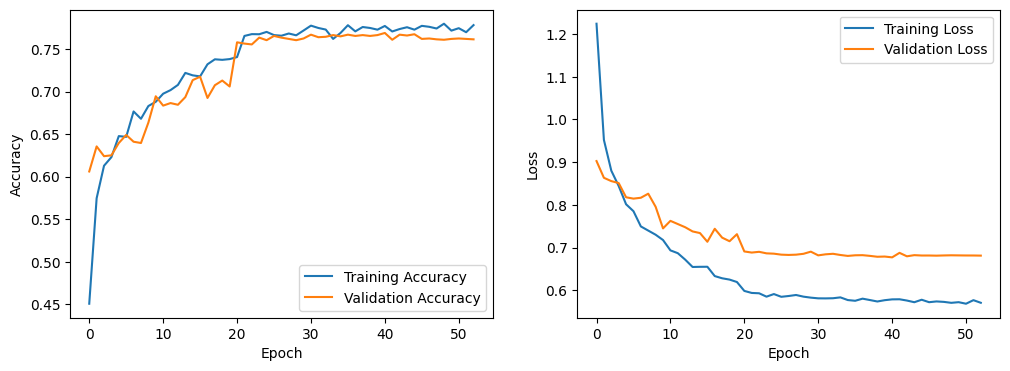

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf

y_true = []
y_pred = []

def get_predictions(dataset):
    for images, labels in dataset:
        predictions = model.predict(images)
        y_true.extend(labels.numpy())
        y_pred.extend(np.argmax(predictions, axis=1))
    return np.array(y_true), np.array(y_pred)

# Get predictions for validation dataset
y_true, y_pred = get_predictions(val_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━

In [19]:
# Classification Report

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=classes))

Classification Report:
              precision    recall  f1-score   support

       akiec       0.55      0.66      0.60        65
         bcc       0.50      0.74      0.60       103
         bkl       0.60      0.73      0.66       220
          df       0.38      0.61      0.47        23
         mel       0.47      0.67      0.55       223
          nv       0.96      0.80      0.87      1341
        vasc       0.68      0.75      0.71        28

    accuracy                           0.77      2003
   macro avg       0.59      0.71      0.64      2003
weighted avg       0.82      0.77      0.78      2003



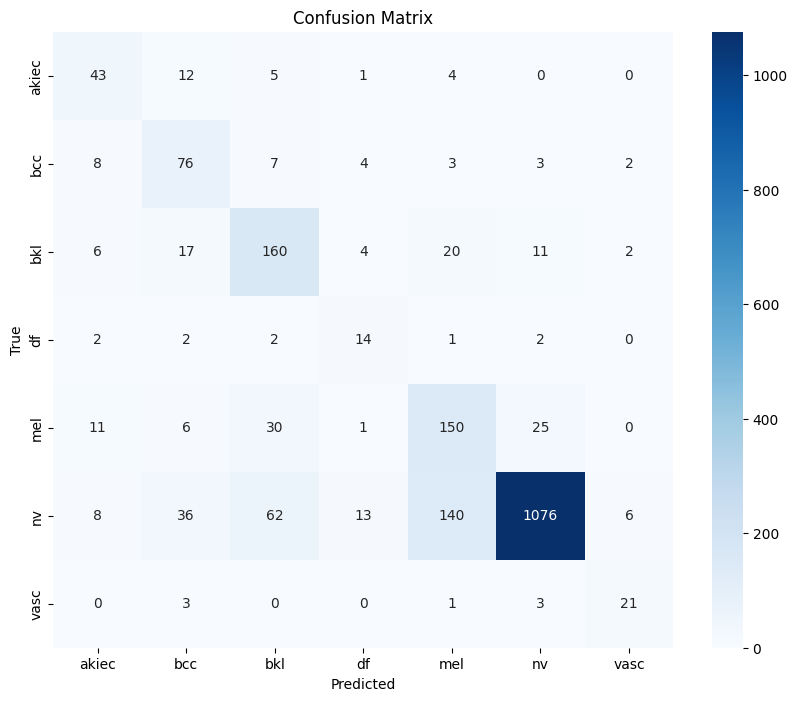

In [20]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

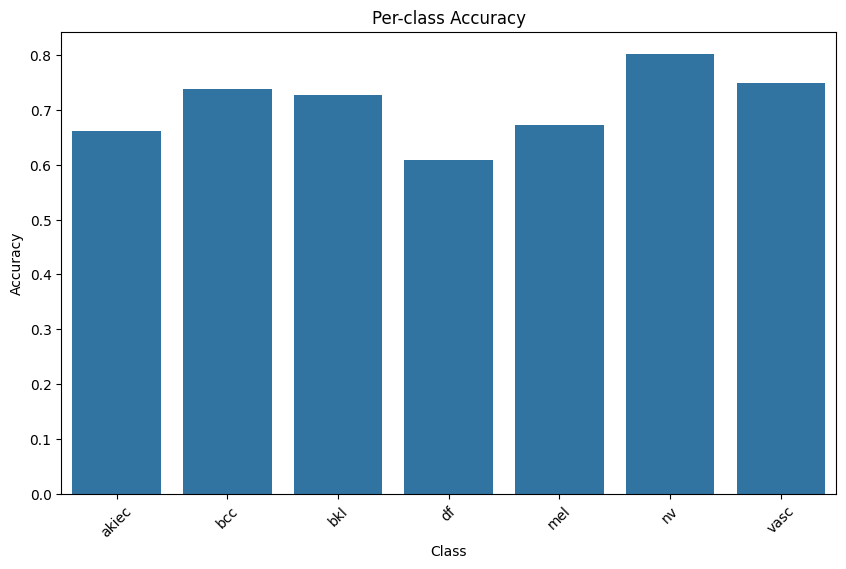

In [21]:
# Per-class Accuracy Plot
class_accuracies = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=class_accuracies)
plt.title('Per-class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()

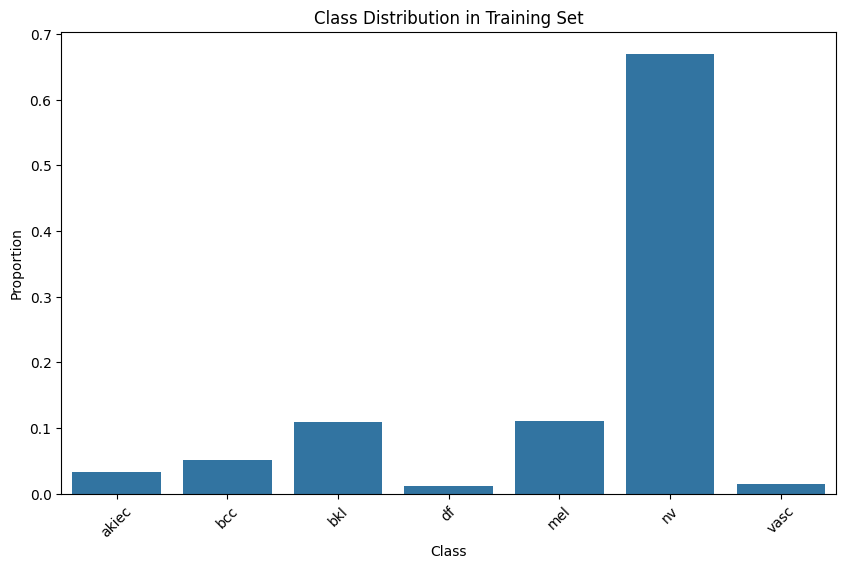

In [22]:
# Class distribution in training set
train_labels = np.concatenate([labels.numpy() for _, labels in train_dataset])
train_class_dist = np.bincount(train_labels) / len(train_labels)

plt.figure(figsize=(10, 6))
sns.barplot(x=classes, y=train_class_dist)
plt.title('Class Distribution in Training Set')
plt.xlabel('Class')
plt.ylabel('Proportion')
plt.xticks(rotation=45)
plt.show()